# <center> Машинное обучение</center>

## Предобработка данных

In [ ]:
import pandas as pd
import warnings
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import confusion_matrix, make_scorer, roc_auc_score, average_precision_score, f1_score, matthews_corrcoef, precision_score, recall_score, accuracy_score, roc_curve, auc

from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer

%matplotlib inline
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None
np.random.seed(123)

# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


Сначала выберем, как определять CD и какой фильтр использовать:
* `CD_TYPE`: где искать компансации для колонки "CD". Если выбрать `117`, поиск будет проводиться в выравнивании со 117 позвоночными; если выбрать `26` – с 26 приматами;
* `FILTER`: какую фильтрацию выборки использовать. Если выбрать `"hard"`, будет использоваться жёсткий фильтр, если `"soft"` – мягкий.

**Жёсткий фильтр**:
- все замены, у которых 'PDBAAMatch' != 1, 'SM.Ide' < 0.95, 'SM.Coverage' <= 0.5 и 'SM.Resol' >= 4.5, были удалены
-все замены, у которых есть признаки с NaN, были удалены

**Мягкий фильтр**:
- значения структурных признаков для замен, у которых `'PDBAAMatch' != 1`, были заменены на `NaN`
- значения 'FoldXddG' для замен, у которых `'PDBAAMatch' != 1`, `'SM.Ide' < 0.95`, `'SM.Coverage' <= 0.5` и `'SM.Resol' >= 4.5` были заменены на `NaN`
далее производилась импутация пропущенных значений медианой для той же ак1 внутри того же RIN класса из выборки случайных замен. на тесте импутация производилась по обучеющей выборке
- RIN класс “Disorder” был заменён на класс “None”, который был оставлен как отдельный класс (он, по идее, соответствует случаю, когда структура не была найдена).

In [ ]:
CD_TYPE = 117
# CD_TYPE = 26

FILTER = "hard"
# FILTER = "soft"

Импортируем данные, отфильтруем ненужное и добавим колонку "CD":

In [ ]:
# read data
print(f"Importing data...")

# don't forget to change the path 
cv_df = pd.read_csv("/content/drive/MyDrive/diploma/ClinVar.191020.main.tsv.bz2", compression='bz2', sep="\t", low_memory=0, na_values=['?'])

print(f"{cv_df.shape[0]} ClinVar variants before filtering.")

# rename so that the name is as in a dataframe with random variants
cv_df.rename(columns={'SM.ClassRIN': 'SimpleClassRIN'}, inplace=True)

# filter "VUS" and "Drug response" variants
cv_df = cv_df[cv_df["CV.SigShort"] != "VUS"]
print(f"{cv_df.shape[0]} ClinVar variants after removal of 'VUS'.")

cv_df = cv_df[cv_df["CV.SigShort"] != "Drug response"]
print(f"{cv_df.shape[0]} ClinVar variants after removal of 'Drug response'.")

# add "CD" column and filter unmapped variants
if CD_TYPE == 26:
  cv_df.dropna(subset=["NumAA2in26Prim"], inplace=True)
  cv_df["NumAA2in26Prim"] = pd.to_numeric(cv_df["NumAA2in26Prim"])
  print(f"{cv_df.shape[0]} variants after removal of '?' in 'NumAA2in26Prim'.")
  
  # add an indicator column for CD
  cv_df["CD"] = cv_df["NumAA2in26Prim"] > 0

elif CD_TYPE == 117:
  cv_df = cv_df.dropna(subset=["NumAA2in117"])
  cv_df["NumAA2in117"] = pd.to_numeric(cv_df["NumAA2in117"])
  print(f"{cv_df.shape[0]} variants after removal of '?' in 'NumAA2in117'.")

  # add an indicator column for CD
  cv_df["CD"] = cv_df["NumAA2in117"] > 0

cv_df["CD"] = cv_df["CD"].map({True: 1, False: 0})

# map sctructure classes to groups
cv_df["SimpleClassRIN"] = cv_df["SimpleClassRIN"].map({
    'Protein interaction': 'Protein_interaction', 
    'Surface': 'Surface',
    'Core': 'Core',
    'ligand interaction': 'Other_interactions',
    'DNA interaction': 'Other_interactions',
    'ion interaction': 'Other_interactions',
    'metal interaction': 'Other_interactions',
    'RNA interaction': 'Other_interactions',
    'Disorder': 'Disorder',
    'None': 'None'
})

# save features
CLASS_FEAT = ['SimpleClassRIN', 'CV.SigShort']
SEL_FEAT = ["PhyloP", "SPOTD.Info", "PPH.dScore", "Grantham",
            "DSSP.NormASA", "B.Zscore", "IntCont", "AveSeqDist", 
            "FoldXddG"]

print('\nColumns:')
cv_df[SEL_FEAT + CLASS_FEAT].info()

print('\nMissing values:')
print(cv_df[SEL_FEAT + CLASS_FEAT].isna().sum(axis=0))

print('\nStructural classes:')
print(cv_df["SimpleClassRIN"].value_counts())

Importing data...
216255 ClinVar variants before filtering.
50968 ClinVar variants after removal of 'VUS'.
50798 ClinVar variants after removal of 'Drug response'.
50798 variants after removal of '?' in 'NumAA2in117'.

Columns:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 50798 entries, 1 to 216254
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PhyloP          50798 non-null  float64
 1   SPOTD.Info      50565 non-null  float64
 2   PPH.dScore      50797 non-null  float64
 3   Grantham        50798 non-null  int64  
 4   DSSP.NormASA    24631 non-null  float64
 5   B.Zscore        24631 non-null  float64
 6   IntCont         26428 non-null  float64
 7   AveSeqDist      26428 non-null  float64
 8   FoldXddG        24420 non-null  float64
 9   SimpleClassRIN  50798 non-null  object 
 10  CV.SigShort     50798 non-null  object 
dtypes: float64(8), int64(1), object(2)
memory usage: 4.7+ MB

Missing values

Проделаем то же самое со случайными мутациями:

In [ ]:
# read data (don't forget to change the path)
print(f"Importing data...")
ran_df = pd.read_csv("/content/drive/MyDrive/diploma/random_preprocessed.csv.gz", compression='gzip', low_memory=0, na_values=['?'])

print(f"{ran_df.shape[0]} random variants before filtering.")

# map sctructure classes to groups
ran_df["SimpleClassRIN"] = ran_df["SimpleClassRIN"].map({
    'Protein interaction': 'Protein_interaction', 
    'Surface': 'Surface',
    'Core': 'Core',
    'ligand interaction': 'Other_interactions',
    'DNA interaction': 'Other_interactions',
    'ion interaction': 'Other_interactions',
    'metal interaction': 'Other_interactions',
    'RNA interaction': 'Other_interactions',
    'Disorder': 'Disorder',
    'None': 'None'
})

RAN_FEAT = ["DSSP.NormASA", "B.Zscore", "IntCont", "AveSeqDist", "FoldXddG", "Grantham"]

print('\nColumns:')
ran_df[RAN_FEAT].info()

print('\nMissing values:')
print(ran_df[RAN_FEAT].isna().sum(axis=0))

Importing data...
190488 random variants before filtering.

Columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190488 entries, 0 to 190487
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   DSSP.NormASA  190482 non-null  float64
 1   B.Zscore      190482 non-null  float64
 2   IntCont       187818 non-null  float64
 3   AveSeqDist    187818 non-null  float64
 4   FoldXddG      190452 non-null  float64
 5   Grantham      190488 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 8.7 MB

Missing values:
DSSP.NormASA       6
B.Zscore           6
IntCont         2670
AveSeqDist      2670
FoldXddG          36
Grantham           0
dtype: int64


Обработаем признаки:

In [ ]:
if FILTER = "hard": 
  # remove poorely mapped variants 
  cv_df_filtered = cv_df.loc[(cv_df['PDBAAMatch'] == 1) & 
                             (cv_df['SM.Ide'] >= 0.95) & 
                             (cv_df['SM.Coverage'] >= 0.5) & 
                             (cv_df['SM.Resol'] <= 4.5)]
  
  # remove variants without at least 1 feature
  cv_df_filtered.dropna(subset=SEL_FEAT + CLASS_FEAT, inplace=True)
  
  # leave necessary columns only 
  cv_df_filtered = cv_df_filtered[["Acc", "CD"] + SEL_FEAT + CLASS_FEAT]
  cv_df_filtered[SEL_FEAT] = cv_df_filtered[SEL_FEAT].apply(pd.to_numeric, errors='coerce')

  # print some statistics
  print(f"\nNumber of variants in df with selected features: {cv_df_filtered.shape[0]}.")

  print('\nNaN values:')
  print(cv_df_filtered.isna().sum(axis=0))

  print('\nStructural classes:')
  print(cv_df_filtered["SimpleClassRIN"].value_counts())

  print('\nClinical significance classes:')
  print(cv_df_filtered["CV.SigShort"].value_counts())

  print('\nCD classes:')
  print(cv_df_filtered["CD"].value_counts())

  print('\nCD & ClinVar classes:')
  print(cv_df_filtered.groupby(["CV.SigShort"])["CD"].value_counts())

elif FILTER = "soft":
  cv_df_filtered = cv_df

  # change feature values of poorely mapped variants to NaNs
  cv_df_filtered.loc[~((cv_df_filtered['PDBAAMatch'] == 1) & 
                       (cv_df_filtered['SM.Ide'] >= 0.95) & 
                       (cv_df_filtered['SM.Coverage'] >= 0.5) & 
                       (cv_df_filtered['SM.Resol'] <= 4.5)), ['FoldXddG']] = np.nan
  cv_df_filtered.loc[(cv_df_filtered['PDBAAMatch'] != 1), STRUCT_FEAT] = np.nan

  # leave necessary columns only 
  cv_df_filtered = cv_df_filtered[["AA1", "Acc", "CD"] + SEL_FEAT + CLASS_FEAT]
  cv_df_filtered[SEL_FEAT] = cv_df_filtered[SEL_FEAT].apply(pd.to_numeric, errors='coerce')

  print('\nNaN values:')
  print(cv_df_filtered.isna().sum(axis=0))

  # change RIN class "Disorder" to "None"
  cv_df_filtered['SimpleClassRIN'].replace({"Disorder": "None"}, inplace=True)

  ## inpute NaNs with medians for random variants (same AA1 & RIN class)
  for aa in cv_df_filtered["AA1"].unique():
    for cl in cv_df_filtered.loc[cv_df_soft["AA1"] == aa, "SimpleClassRIN"].unique():
      for p in RAN_FEAT:
        cv_df_filtered.loc[(cv_df_filtered.AA1 == aa) & 
                           (cv_df_filtered.SimpleClassRIN == cl) & 
                           (cv_df_filtered[p].isna()), p] = ran_df.loc[(ran_df.AA1 == aa) & 
                                                                       (ran_df.SimpleClassRIN == cl), p].median()
  # don't need "AA1" column anymore                                                                    
  cv_df_filtered.drop(columns=["AA1"], inplace=True)

  # print some statistics
  print(f"\nNumber of variants in df with selected features: {cv_df_filtered.shape[0]}.")

  print('\nNaN values (after imputation):')
  print(cv_df_filtered.isna().sum(axis=0))

  print('\nStructural classes:')
  print(cv_df_filtered["SimpleClassRIN"].value_counts())

  print('\nClinical significance classes:')
  print(cv_df_filtered["CV.SigShort"].value_counts())

  print('\nCD classes:')
  print(cv_df_filtered["CD"].value_counts())

  print('\nCD & ClinVar classes:')
  print(cv_df_filtered.groupby(["CV.SigShort"])["CD"].value_counts())



NaN values:
AA1                   0
Acc                   0
CPD                   0
PhyloP                0
SPOTD.Info          233
PPH.dScore            1
Grantham          25342
DSSP.NormASA      26324
B.Zscore          26324
IntCont           26292
AveSeqDist        26292
FoldXddG          40195
SimpleClassRIN        0
CV.SigShort           0
dtype: int64

Number of variants in df with selected features: 50798.

NaN values (after imputation):
Acc                 0
CPD                 0
PhyloP              0
SPOTD.Info        233
PPH.dScore          1
Grantham            0
DSSP.NormASA        0
B.Zscore            0
IntCont             0
AveSeqDist          0
FoldXddG            0
SimpleClassRIN      0
CV.SigShort         0
dtype: int64

Structural classes:
None                   18727
Core                   10551
Protein_interaction     8609
Surface                 8562
Other_interactions      4349
Name: SimpleClassRIN, dtype: int64

Clinical significance classes:
Pathogenic    318

Закодируем два категориальных признака (так как реализация sklearn не умеет с ними работать из коробки) с помощью [numerical encoding](https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931). Заодно сделаем 3 таблицы с филогенетическими, структурными и всеми признаками.

In [ ]:
# create 3 data frames
cv_df_phyl = cv_df_filtered[["Acc", "CD", "CV.SigShort"] + PHYL_FEAT]
cv_df_str = cv_df_filtered[["Acc", "CD"] + STRUCT_FEAT + CLASS_FEAT]
cv_df_all = cv_df_filtered

# encode RIN class
enc_all = OrdinalEncoder()
cv_df_all["SimpleClassRIN"] = enc_all.fit_transform(cv_df_all[["SimpleClassRIN"]])

enc_str = OrdinalEncoder()
cv_df_str["SimpleClassRIN"] = enc_str.fit_transform(cv_df_str[["SimpleClassRIN"]])

# encode target variable
cv_df_all["CV.SigShort"] = cv_df_all["CV.SigShort"].map({"Pathogenic": 1, "Benign": 0})
cv_df_phyl["CV.SigShort"] = cv_df_phyl["CV.SigShort"].map({"Pathogenic": 1, "Benign": 0})
cv_df_str["CV.SigShort"] = cv_df_str["CV.SigShort"].map({"Pathogenic": 1, "Benign": 0})

cv_df_all.head()

,Acc,CPD,PhyloP,SPOTD.Info,PPH.dScore,Grantham,DSSP.NormASA,B.Zscore,IntCont,AveSeqDist,FoldXddG,SimpleClassRIN,CV.SigShort
1,P05161,1,-0.676,0.53,-0.430,46.0,1.0200,3.62,4.0,1.50,-0.298537,4.0,0
9,P05161,1,-0.396,0.51,0.387,112.0,0.3360,-0.04,9.0,8.90,0.151437,3.0,0
14,P05161,1,0.151,0.77,1.007,98.0,0.2815,-0.07,8.0,8.50,3.195160,3.0,0
17,P05161,1,-2.665,0.45,-0.213,101.0,0.4620,0.24,11.0,12.55,0.479447,4.0,0
19,O00468,1,-1.405,0.45,-0.322,97.0,0.3890,0.67,10.0,31.00,0.755081,1.0,0


## Разработка моделей

Создадим несколько полезных функций.

In [ ]:
def calc_metrics(y_true, y_pred, y_proba):
  """
  Calculate multiple metrics.
  Args:
    y_true: true y values. 
    y_pred: predicted y values (classes). 
    y_proba: predicted y values (scores/probabilities). 
  Returns:
    a dict with metrics.
  """
  scores = {}

  scores["Accuracy"] = accuracy_score(y_true, y_pred)
  scores["MCC"] = matthews_corrcoef(y_true, y_pred)
  scores["F1"] = f1_score(y_true, y_pred)
  scores["Precision"] = precision_score(y_true, y_pred)
  scores["Recall"] = recall_score(y_true, y_pred)
  scores["ROC-AUC"] = roc_auc_score(y_true, y_proba)
  scores["PR-AUC"] = average_precision_score(y_true, y_proba)

  return scores


def calc_AUC(y_true, y_pred):
  """
  Calculate values for ROC-AUC.
  Args:
    y_true: true y values. 
    y_pred: predicted y values (scores). 
  Returns:
    TPR, FPR and thresholds.
  """
  fpr, tpr, thrs = roc_curve(y_true, y_pred)

  return {"FPR": fpr, "TPR": tpr, "THR": thrs}


def calculate_summary(y_true, y_pred, y_proba, cds):
  """
  Calculate metrics values and print confusion matrices
  (used for each round/split).
  Args:
    y_true: true y values. 
    y_pred: predicted y values (classes). 
    y_proba: predicted y values (scores/probabilities). 
    cds: CD-statuses of variants.
  Returns:
    confusion matrices, metrics for CDs/non-CDs, AUCROCs. 
  """
  res = {}
  scores = {"MCC": [], "F1": [], 
            "Precision": [], "Recall": [], 'Accuracy': [],
            'ROC-AUC': [], "PR-AUC": []}
  
  # calculate and print confusion matrix for all variants
  conf_m = confusion_matrix(y_true, y_pred)
  res["TN"] = [conf_m[0][0], conf_m[0][0]/conf_m.sum(axis=1)[0] * 100]
  res["FP"] = [conf_m[0][1], conf_m[0][1]/conf_m.sum(axis=1)[0] * 100]
  res["FN"] = [conf_m[1][0], conf_m[1][0]/conf_m.sum(axis=1)[1] * 100]
  res["TP"] = [conf_m[1][1], conf_m[1][1]/conf_m.sum(axis=1)[1] * 100]
  
  print("Confusion matrix for all:")
  print("TRUE\PRED\t0\t\t1")
  print("0\t\t{}({:.2f}%)\t{}({:.2f}%)".format(*res["TN"], *res["FP"]))
  print("1\t\t{}({:.2f}%)\t{}({:.2f}%)".format(*res["FN"], *res["TP"]))
  print()

  # calculate and print confusion matrix for CD variants
  conf_m = confusion_matrix(y_true[cds == 1], y_pred[cds == 1])
  res["CD_TN"] = [conf_m[0][0], conf_m[0][0]/conf_m.sum(axis=1)[0] * 100]
  res["CD_FP"] = [conf_m[0][1], conf_m[0][1]/conf_m.sum(axis=1)[0] * 100]
  res["CD_FN"] = [conf_m[1][0], conf_m[1][0]/conf_m.sum(axis=1)[1] * 100]
  res["CD_TP"] = [conf_m[1][1], conf_m[1][1]/conf_m.sum(axis=1)[1] * 100]

  print("Confusion matrix for CD:")
  print("TRUE\PRED\t0\t\t1")
  print("0\t\t{}({:.2f}%)\t{}({:.2f}%)".format(*res["CD_TN"], *res["CD_FP"]))
  print("1\t\t{}({:.2f}%)\t{}({:.2f}%)".format(*res["CD_FN"], *res["CD_TP"]))
  print()

  # calculate and print confusion matrix for non-CD variants
  conf_m = confusion_matrix(y_true[cds == 0], y_pred[cds == 0])
  res["nCD_TN"] = [conf_m[0][0], conf_m[0][0]/conf_m.sum(axis=1)[0] * 100]
  res["nCD_FP"] = [conf_m[0][1], conf_m[0][1]/conf_m.sum(axis=1)[0] * 100]
  res["nCD_FN"] = [conf_m[1][0], conf_m[1][0]/conf_m.sum(axis=1)[1] * 100]
  res["nCD_TP"] = [conf_m[1][1], conf_m[1][1]/conf_m.sum(axis=1)[1] * 100]

  print("Confusion matrix for non-CD:")
  print("TRUE\PRED\t0\t\t1")
  print("0\t\t{}({:.2f}%)\t{}({:.2f}%)".format(*res["nCD_TN"], *res["nCD_FP"]))
  print("1\t\t{}({:.2f}%)\t{}({:.2f}%)".format(*res["nCD_FN"], *res["nCD_TP"]))

  aucs = {"all": calc_AUC(y_true, y_proba),
          "CD": calc_AUC(y_true[cds == 1], y_proba[cds == 1]),
          "nCD": calc_AUC(y_true[cds == 0], y_proba[cds == 0])}

  metrics_CDs = calc_metrics(y_true[cds == 1], y_pred[cds == 1], y_proba[cds == 1])
  metrics_nCDs = calc_metrics(y_true[cds == 0], y_pred[cds == 0], y_proba[cds == 0])
  for s in metrics_CDs.keys(): scores[s] = [metrics_CDs[s], metrics_nCDs[s]]

  return res, scores, aucs
  

def summary_report(res):
  """
  Print final summary report for the model (used at the end).
  Args:
    res: results of the model.
  """
  scores, conf_m, auc_dict = res

  # print confusion matrix for all variants: mean ± std
  print("Confusion matrix for all:")
  print("TRUE\PRED\t0\t\t1")
  print("0\t\t{:.2f} ± {:.2f}%\t{:.2f} ± {:.2f}%".format(
      np.array(conf_m["TN"]).mean(axis=0)[1],
      np.array(conf_m["TN"]).std(axis=0)[1],
      np.array(conf_m["FP"]).mean(axis=0)[1],
      np.array(conf_m["FP"]).std(axis=0)[1]))
  
  print("1\t\t{:.2f} ± {:.2f}%\t{:.2f} ± {:.2f}%".format(
      np.array(conf_m["FN"]).mean(axis=0)[1],
      np.array(conf_m["FN"]).std(axis=0)[1],
      np.array(conf_m["TP"]).mean(axis=0)[1],
      np.array(conf_m["TP"]).std(axis=0)[1]))
  print()

  # print confusion matrix for CD variants: mean ± std
  print("Confusion matrix for CD:")
  print("TRUE\PRED\t0\t\t1")
  print("0\t\t{:.2f} ± {:.2f}%\t{:.2f} ± {:.2f}%".format(
      np.array(conf_m["CD_TN"]).mean(axis=0)[1],
      np.array(conf_m["CD_TN"]).std(axis=0)[1],
      np.array(conf_m["CD_FP"]).mean(axis=0)[1],
      np.array(conf_m["CD_FP"]).std(axis=0)[1]))
  print("1\t\t{:.2f} ± {:.2f}%\t{:.2f} ± {:.2f}%".format(
      np.array(conf_m["CD_FN"]).mean(axis=0)[1],
      np.array(conf_m["CD_FN"]).std(axis=0)[1],
      np.array(conf_m["CD_TP"]).mean(axis=0)[1],
      np.array(conf_m["CD_TP"]).std(axis=0)[1]))
  print()

  # print confusion matrix for non-CD variants: mean ± std
  print("Confusion matrix for non-CD:")
  print("TRUE\PRED\t0\t\t1")
  print("0\t\t{:.2f} ± {:.2f}%\t{:.2f} ± {:.2f}%".format(
      np.array(conf_m["nCD_TN"]).mean(axis=0)[1],
      np.array(conf_m["nCD_TN"]).std(axis=0)[1],
      np.array(conf_m["nCD_FP"]).mean(axis=0)[1],
      np.array(conf_m["nCD_FP"]).std(axis=0)[1]))
  print("1\t\t{:.2f} ± {:.2f}%\t{:.2f} ± {:.2f}%".format(
      np.array(conf_m["nCD_FN"]).mean(axis=0)[1],
      np.array(conf_m["nCD_FN"]).std(axis=0)[1],
      np.array(conf_m["nCD_TP"]).mean(axis=0)[1],
      np.array(conf_m["nCD_TP"]).std(axis=0)[1]))
  print()

  # calculate mean metrics values for the model
  print("------------------------------------ SUMMARY ------------------------------------")
  for s in ["MCC", "F1", "Precision", "Recall", 'Accuracy', 'ROC-AUC', "PR-AUC"]:
    train_scores = np.array([score[0] for score in scores[s]])
    test_scores = np.array([score[1] for score in scores[s]])
    CD_test_scores = np.array([score[2] for score in scores[s]])
    nCD_test_scores = np.array([score[3] for score in scores[s]])
    
    # print mean ± 2std for the model
    print(f"{s} on train = {train_scores.mean():.3f} ± {2 * train_scores.std():.3f}.")
    print(f"{s} on test = {test_scores.mean():.3f} ± {2 * test_scores.std():.3f}.")
    print(f"{s} on CDs (test) = {CD_test_scores.mean():.3f} ± {2 * test_scores.std():.3f}.")
    print(f"{s} on non-CDs (test) = {nCD_test_scores.mean():.3f} ± {2 * test_scores.std():.3f}.")

    print()
  return


def plot_AUC(auc_dict, thr=20, verbose=False):
    """
    Plot ROC-AUC.
    Args:
      auc_dict: dict with AUC values.
      thr: a threshold to show (FPR=20%).
      verbose: whether to print log messages.
    """
    dd = pd.DataFrame.from_dict(auc_dict)
    stats = {"all": [], "CD": [], "nCD": []}

    fig, ax = plt.subplots(figsize=(8,5))
    sns.lineplot(data=dd, x="FPR", y="TPR", hue="Type", err_style="bars", lw=3)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
        
    plt.title('ROC')
    plt.legend(loc="lower right")    
    plt.show();
    
    return


def summary_plots(res):
  """
  Plot summary plots.
  Args:
    res: results of a model.
  """
  scores, conf_m, auc_dict = res
  plot_AUC(auc_dict)
  
  return

In [ ]:
def run_forest(grid, df, n=10, CD=False):
  """
  Run a RandomForest model.
  Args:
    grid: `max_features` values for tuning. 
    df: a dataframe with features and target variable.
    n: number of rounds (random train/test splitting). 
  Returns:
    scores: a dict with metrics for each round.
    conf_m: a confusion matrix for each round. 
    auc_dict: TPR, FPR and thresholds for each round.
  """
  mcc_scorer = make_scorer(matthews_corrcoef) # MCC function for later

  # dicts to return
  scores = {"Run_n": list(range(n)), "Best_param": [],
            "MCC": [], "F1": [], 
            "Precision": [], "Recall": [], 'Accuracy': [],
            'ROC-AUC': [], "PR-AUC": [], "Params": grid}
  conf_m = {"TN": [], "FP": [], "FN": [], "TP": [],
            "CD_TN": [], "CD_FP": [], "CD_FN": [], "CD_TP": [],
            "nCD_TN": [], "nCD_FP": [], "nCD_FN": [], "nCD_TP": []}
  auc_dict = {"Run": [], "TPR": [], "FPR": [], "THR": []}

  # split input dataframe into X, y and protein groups
  X, y, groups = df.drop(columns=["Acc",	'CV.SigShort'], axis=1), df['CV.SigShort'], df['Acc']

  for i in range(n):
    print()
    print("-------------------------------- ROUND ", i, "--------------------------------")

    # split into train and test (different proteins)
    train_inds, test_inds = next(GroupShuffleSplit(random_state=i).split(X, y, groups=groups))

    # save CD_statuses
    cds_test = X.iloc[test_inds]["CD"]
    cds_train = X.iloc[train_inds]["CD"]
    
    # make a sample for train and test
    X_train, X_test, y_train, y_test = X.iloc[train_inds], X.iloc[test_inds], y.iloc[train_inds], y.iloc[test_inds]
    if not CD:
      X_train.drop(columns=["CD"], axis=1, inplace=True)
      X_test.drop(columns=["CD"], axis=1, inplace=True)
    
    # impute NaNs in both samples with feature medians
    si = SimpleImputer(strategy='median')
    X_train = si.fit_transform(X_train)
    X_test = si.transform(X_test)

    # perform hyperparameter tuning
    best_score = 0
    for k in grid:
      rfc = RandomForestClassifier(random_state=42, oob_score=True, max_features=k)
      rfc.fit(X_train, y_train)
      pred_train = np.argmax(rfc.oob_decision_function_, axis=1)
      curr_score = matthews_corrcoef(y_train, pred_train)

      # update if better results
      if curr_score > best_score:
        best_score = curr_score
        best_parameter = k
        best_model = rfc

    print()
    print("Best score for round {}: {:.2f}".format(i, best_score))
    print("Best parameter for round {}: {}".format(i, best_parameter))

    # get predictions for the best model in this round
    pred_train = np.argmax(best_model.oob_decision_function_, axis=1)
    pred_test = best_model.predict(X_test)
    proba_train = best_model.oob_decision_function_[:, 1]
    proba_test = best_model.predict_proba(X_test)[:, 1]

    # calculate metrics for the best model in this round
    metrics_train = calc_metrics(y_train, pred_train, proba_train)
    metrics_test = calc_metrics(y_test, pred_test, proba_test)
    scores["Best_param"].append(best_parameter)

    # report results for the round
    print()
    print("PREDICTIONS ON TRAIN:")
    print("-------------------------------")
    predict_cd(y_train, pred_train, proba_train, cds_train)
      
    print()
    print("PREDICTIONS ON TEST:")
    print("-------------------------------")
    res = predict_cd(y_test, pred_test, proba_test, cds_test)

    # save results for each round
    for s in metrics_train.keys(): scores[s].append([metrics_train[s], metrics_test[s], res[1][s][0], res[1][s][1]])
    for i in conf_m: conf_m[i].append(res[0][i]) 

    auc_dict = {"Run": [], "TPR": [], "FPR": [], "THR": [], "Type": []}
    for t in ["all", "CD", "nCD"]:
      for n in range(len(res[2][t])):
        auc_dict["Run"].extend(["i"] * len(res[2][t]["THR"]))
        auc_dict["Type"].extend([t] * len(res[2][t]["THR"]))
        auc_dict["TPR"].extend(res[2][t]["TPR"])
        auc_dict["FPR"].extend(res[2][t]["FPR"])
        auc_dict["THR"].extend(res[2][t]["THR"])

  return scores, conf_m, auc_dict

### Лес на 10 признаках (филогенетические + структурные)

In [ ]:
max_feat_grid = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
scores_all = run_forest(max_feat_grid, cv_df_all)


-------------------------------- ROUND  0 --------------------------------

Best score for round 0: 0.60
Best parameter for round 0: 3

PREDICTIONS ON TRAIN:
-------------------------------
Confusion matrix for all:
TRUE\PRED	0		1
0		777(56.76%)	592(43.24%)
1		259(3.49%)	7162(96.51%)

Confusion matrix for CD:
TRUE\PRED	0		1
0		630(78.26%)	175(21.74%)
1		140(25.00%)	420(75.00%)

Confusion matrix for non-CD:
TRUE\PRED	0		1
0		147(26.06%)	417(73.94%)
1		119(1.73%)	6742(98.27%)

PREDICTIONS ON TEST:
-------------------------------
Confusion matrix for all:
TRUE\PRED	0		1
0		167(52.52%)	151(47.48%)
1		34(2.39%)	1389(97.61%)

Confusion matrix for CD:
TRUE\PRED	0		1
0		133(79.17%)	35(20.83%)
1		14(11.02%)	113(88.98%)

Confusion matrix for non-CD:
TRUE\PRED	0		1
0		34(22.67%)	116(77.33%)
1		20(1.54%)	1276(98.46%)

-------------------------------- ROUND  1 --------------------------------

Best score for round 1: 0.60
Best parameter for round 1: 10

PREDICTIONS ON TRAIN:
----------------------

Confusion matrix for all:
TRUE\PRED	0		1
0		55.85 ± 2.56%	44.15 ± 2.56%
1		3.48 ± 0.61%	96.52 ± 0.61%

Confusion matrix for CD:
TRUE\PRED	0		1
0		78.40 ± 1.80%	21.60 ± 1.80%
1		24.66 ± 5.81%	75.34 ± 5.81%

Confusion matrix for non-CD:
TRUE\PRED	0		1
0		26.44 ± 4.01%	73.56 ± 4.01%
1		1.71 ± 0.23%	98.29 ± 0.23%

------------------------------------ SUMMARY ------------------------------------
MCC on train = 0.605 ± 0.012.
MCC on test = 0.591 ± 0.025.
MCC on CDs (test) = 0.533 ± 0.025.
MCC on non-CDs (test) = 0.353 ± 0.025.

F1 on train = 0.943 ± 0.004.
F1 on test = 0.942 ± 0.011.
F1 on CDs (test) = 0.733 ± 0.011.
F1 on non-CDs (test) = 0.960 ± 0.011.

Precision on train = 0.921 ± 0.006.
Precision on test = 0.921 ± 0.027.
Precision on CDs (test) = 0.717 ± 0.027.
Precision on non-CDs (test) = 0.938 ± 0.027.

Recall on train = 0.967 ± 0.005.
Recall on test = 0.965 ± 0.012.
Recall on CDs (test) = 0.753 ± 0.012.
Recall on non-CDs (test) = 0.983 ± 0.012.

Accuracy on train = 0.902 ± 0.006.
Acc

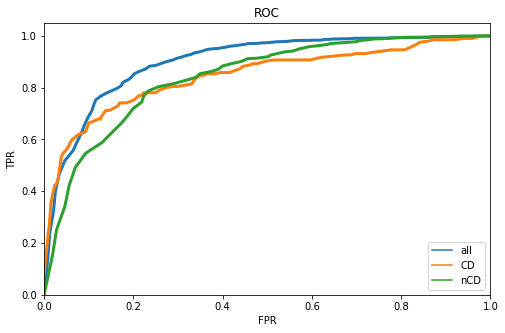

In [ ]:
summary_report(scores_all)
summary_plots(scores_all)

### Филогенетические признаки

In [ ]:
max_feat_grid = [1, 2, 3]
scores_phyl = run_forest(max_feat_grid, cv_df_phyl)


-------------------------------- ROUND  0 --------------------------------

Best score for round 0: 0.56
Best parameter for round 0: 1

PREDICTIONS ON TRAIN:
-------------------------------
Confusion matrix for all:
TRUE\PRED	0		1
0		724(52.89%)	645(47.11%)
1		284(3.83%)	7137(96.17%)

Confusion matrix for CD:
TRUE\PRED	0		1
0		604(75.03%)	201(24.97%)
1		139(24.82%)	421(75.18%)

Confusion matrix for non-CD:
TRUE\PRED	0		1
0		120(21.28%)	444(78.72%)
1		145(2.11%)	6716(97.89%)

PREDICTIONS ON TEST:
-------------------------------
Confusion matrix for all:
TRUE\PRED	0		1
0		159(50.00%)	159(50.00%)
1		43(3.02%)	1380(96.98%)

Confusion matrix for CD:
TRUE\PRED	0		1
0		128(76.19%)	40(23.81%)
1		17(13.39%)	110(86.61%)

Confusion matrix for non-CD:
TRUE\PRED	0		1
0		31(20.67%)	119(79.33%)
1		26(2.01%)	1270(97.99%)

-------------------------------- ROUND  1 --------------------------------

Best score for round 1: 0.58
Best parameter for round 1: 1

PREDICTIONS ON TRAIN:
-----------------------

Confusion matrix for all:
TRUE\PRED	0		1
0		53.08 ± 2.51%	46.92 ± 2.51%
1		4.58 ± 0.94%	95.42 ± 0.94%

Confusion matrix for CD:
TRUE\PRED	0		1
0		75.43 ± 1.73%	24.57 ± 1.73%
1		25.00 ± 5.88%	75.00 ± 5.88%

Confusion matrix for non-CD:
TRUE\PRED	0		1
0		24.02 ± 3.30%	75.98 ± 3.30%
1		2.85 ± 0.69%	97.15 ± 0.69%

------------------------------------ SUMMARY ------------------------------------
MCC on train = 0.565 ± 0.025.
MCC on test = 0.538 ± 0.061.
MCC on CDs (test) = 0.498 ± 0.061.
MCC on non-CDs (test) = 0.276 ± 0.061.

F1 on train = 0.937 ± 0.005.
F1 on test = 0.934 ± 0.008.
F1 on CDs (test) = 0.717 ± 0.008.
F1 on non-CDs (test) = 0.953 ± 0.008.

Precision on train = 0.916 ± 0.006.
Precision on test = 0.916 ± 0.026.
Precision on CDs (test) = 0.690 ± 0.026.
Precision on non-CDs (test) = 0.935 ± 0.026.

Recall on train = 0.960 ± 0.005.
Recall on test = 0.954 ± 0.019.
Recall on CDs (test) = 0.750 ± 0.019.
Recall on non-CDs (test) = 0.971 ± 0.019.

Accuracy on train = 0.892 ± 0.007.
Acc

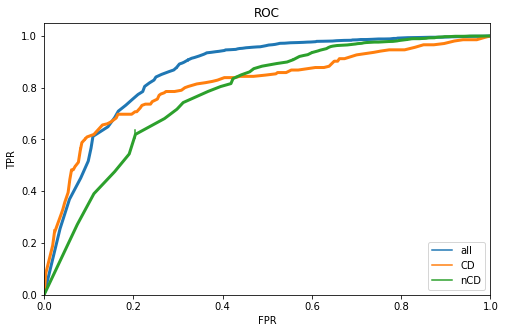

In [ ]:
summary_report(scores_phyl)
summary_plots(scores_phyl)

### Структурные признаки

In [ ]:
max_feat_grid = [1, 2, 3, 4, 5, 6, 7]
scores_str = run_forest(max_feat_grid, cv_df_str)


-------------------------------- ROUND  0 --------------------------------

Best score for round 0: 0.33
Best parameter for round 0: 5

PREDICTIONS ON TRAIN:
-------------------------------
Confusion matrix for all:
TRUE\PRED	0		1
0		438(31.99%)	931(68.01%)
1		384(5.17%)	7037(94.83%)

Confusion matrix for CD:
TRUE\PRED	0		1
0		312(38.76%)	493(61.24%)
1		60(10.71%)	500(89.29%)

Confusion matrix for non-CD:
TRUE\PRED	0		1
0		126(22.34%)	438(77.66%)
1		324(4.72%)	6537(95.28%)

PREDICTIONS ON TEST:
-------------------------------
Confusion matrix for all:
TRUE\PRED	0		1
0		98(30.82%)	220(69.18%)
1		63(4.43%)	1360(95.57%)

Confusion matrix for CD:
TRUE\PRED	0		1
0		66(39.29%)	102(60.71%)
1		7(5.51%)	120(94.49%)

Confusion matrix for non-CD:
TRUE\PRED	0		1
0		32(21.33%)	118(78.67%)
1		56(4.32%)	1240(95.68%)

-------------------------------- ROUND  1 --------------------------------

Best score for round 1: 0.33
Best parameter for round 1: 4

PREDICTIONS ON TRAIN:
---------------------------

Confusion matrix for all:
TRUE\PRED	0		1
0		32.42 ± 3.14%	67.58 ± 3.14%
1		4.93 ± 0.69%	95.07 ± 0.69%

Confusion matrix for CD:
TRUE\PRED	0		1
0		39.71 ± 3.84%	60.29 ± 3.84%
1		10.79 ± 2.16%	89.21 ± 2.16%

Confusion matrix for non-CD:
TRUE\PRED	0		1
0		22.92 ± 3.37%	77.08 ± 3.37%
1		4.45 ± 0.69%	95.55 ± 0.69%

------------------------------------ SUMMARY ------------------------------------
MCC on train = 0.352 ± 0.026.
MCC on test = 0.344 ± 0.046.
MCC on CDs (test) = 0.319 ± 0.046.
MCC on non-CDs (test) = 0.212 ± 0.046.

F1 on train = 0.914 ± 0.005.
F1 on test = 0.915 ± 0.019.
F1 on CDs (test) = 0.656 ± 0.019.
F1 on non-CDs (test) = 0.944 ± 0.019.

Precision on train = 0.880 ± 0.010.
Precision on test = 0.883 ± 0.035.
Precision on CDs (test) = 0.521 ± 0.035.
Precision on non-CDs (test) = 0.934 ± 0.035.

Recall on train = 0.952 ± 0.009.
Recall on test = 0.951 ± 0.014.
Recall on CDs (test) = 0.892 ± 0.014.
Recall on non-CDs (test) = 0.956 ± 0.014.

Accuracy on train = 0.851 ± 0.008.
Acc

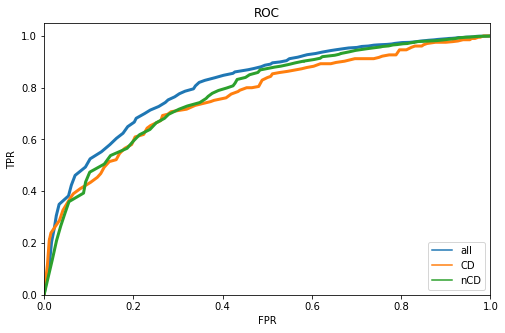

In [ ]:
summary_report(scores_str)
summary_plots(scores_str)

### Лес с CD
Попробуем добавить признак "CD" в общий лес и посмотрим, улучшит ли это результаты.

In [ ]:
max_feat_grid = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
scores_cd_forest = run_forest(max_feat_grid, cv_df_all, CD=True)

-------------------------------- ROUND  0 --------------------------------

Best score for round 0: 0.60
Best parameter for round 0: 3

PREDICTIONS ON TRAIN:
-------------------------------
Confusion matrix for all:
TRUE\PRED	0		1
0		773(56.46%)	596(43.54%)
1		246(3.31%)	7175(96.69%)

Confusion matrix for CD:
TRUE\PRED	0		1
0		665(82.61%)	140(17.39%)
1		172(30.71%)	388(69.29%)

Confusion matrix for non-CD:
TRUE\PRED	0		1
0		108(19.15%)	456(80.85%)
1		74(1.08%)	6787(98.92%)

PREDICTIONS ON TEST:
-------------------------------
Confusion matrix for all:
TRUE\PRED	0		1
0		170(53.46%)	148(46.54%)
1		37(2.60%)	1386(97.40%)

Confusion matrix for CD:
TRUE\PRED	0		1
0		145(86.31%)	23(13.69%)
1		25(19.69%)	102(80.31%)

Confusion matrix for non-CD:
TRUE\PRED	0		1
0		25(16.67%)	125(83.33%)
1		12(0.93%)	1284(99.07%)
-------------------------------- ROUND  1 --------------------------------

Best score for round 1: 0.63
Best parameter for round 1: 2

PREDICTIONS ON TRAIN:
--------------------------

Confusion matrix for all:
TRUE\PRED	0		1
0		57.48 ± 3.49%	42.52 ± 3.49%
1		3.74 ± 0.86%	96.26 ± 0.86%

Confusion matrix for CD:
TRUE\PRED	0		1
0		86.14 ± 1.90%	13.86 ± 1.90%
1		33.99 ± 7.55%	66.01 ± 7.55%

Confusion matrix for non-CD:
TRUE\PRED	0		1
0		20.17 ± 3.94%	79.83 ± 3.94%
1		1.20 ± 0.26%	98.80 ± 0.26%

------------------------------------ SUMMARY ------------------------------------
MCC on train = 0.614 ± 0.018.
MCC on test = 0.596 ± 0.055.
MCC on CDs (test) = 0.535 ± 0.055.
MCC on non-CDs (test) = 0.314 ± 0.055.

F1 on train = 0.944 ± 0.004.
F1 on test = 0.943 ± 0.011.
F1 on CDs (test) = 0.710 ± 0.011.
F1 on non-CDs (test) = 0.960 ± 0.011.

Precision on train = 0.923 ± 0.005.
Precision on test = 0.924 ± 0.027.
Precision on CDs (test) = 0.775 ± 0.027.
Precision on non-CDs (test) = 0.933 ± 0.027.

Recall on train = 0.965 ± 0.005.
Recall on test = 0.963 ± 0.017.
Recall on CDs (test) = 0.660 ± 0.017.
Recall on non-CDs (test) = 0.988 ± 0.017.

Accuracy on train = 0.904 ± 0.006.
Acc

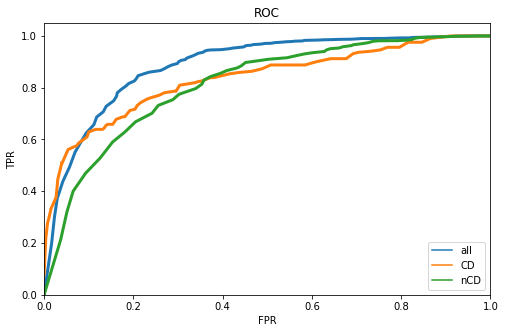

In [ ]:
summary_report(scores_cd_forest)
summary_plots(scores_cd_forest)

Сохранить результаты, если нужно:

In [ ]:
from pickle import dump, load
with open('/content/drive/MyDrive/diploma/scores_forest_all_features.pickle', 'wb') as f: dump(scores_all, f)
with open('/content/drive/MyDrive/diploma/scores_forest_phyl_features.pickle', 'wb') as f: dump(scores_phyl, f)
with open('/content/drive/MyDrive/diploma/scores_forest_str_features.pickle', 'wb') as f: dump(scores_str, f)
with open('/content/drive/MyDrive/diploma/scores_forest_with_CD.pickle', 'wb') as f: dump(scores_cd_forest, f)

# rbc_loaded = load('/content/drive/MyDrive/diploma/rfc_struct.joblib')

### Baseline
Сделаем baseline-модель, в которой если замена CD, то выбирается структурное предсказание, а иначе – филогенетическое.

In [ ]:
def run_baseline_model(df, n=10):
  """
  Run a bseline model that takes structural RF's predictions for CD and
  phylogenetic RF's predictions for non-CD.
  Args:
    grid: `max_features` values for tuning. 
    df: a dataframe with features and target variable.
    n: number of rounds (random train/test splitting). 
  Returns:
    scores: a dict with metrics for each round.
    conf_m: a confusion matrix for each round. 
    auc_dict: TPR, FPR and thresholds for each round.
  """
  mcc_scorer = make_scorer(matthews_corrcoef) # MCC function for later

  # dicts to return
  scores = {"Run_n": list(range(n)),
            "MCC": [], "F1": [], 
            "Precision": [], "Recall": [], 'Accuracy': [],
            'ROC-AUC': [], "PR-AUC": [], "Params": grid}
  conf_m = {"TN": [], "FP": [], "FN": [], "TP": [],
            "CD_TN": [], "CD_FP": [], "CD_FN": [], "CD_TP": [],
            "nCD_TN": [], "nCD_FP": [], "nCD_FN": [], "nCD_TP": []}
  auc_dict = {"Run": [], "TPR": [], "FPR": [], "THR": []}

  # split input dataframe into X, y and protein groups
  X, y, groups = df.drop(columns=["Acc",	'CV.SigShort'], axis=1), df['CV.SigShort'], df['Acc']

  for i in range(n):
    print()
    print("-------------------------------- ROUND ", i, "--------------------------------")

    # split into train and test (different proteins)
    train_inds, test_inds = next(GroupShuffleSplit(random_state=i).split(X, y, groups=groups))

    # save CD_statuses
    cds_test = X.iloc[test_inds]["CD"]
    cds_train = X.iloc[train_inds]["CD"]
    
    # make a sample for train and test
    X_train, X_test, y_train, y_test = X.iloc[train_inds], X.iloc[test_inds], y.iloc[train_inds], y.iloc[test_inds]

    # make separate dataframes for 2 RFs
    X_train_phyl, X_train_str = X_train[PHYL_FEAT], X_train[STRUCT_FEAT + ['SimpleClassRIN']]
    X_test_phyl, X_test_str = X_test[PHYL_FEAT], X_test[STRUCT_FEAT  + ['SimpleClassRIN']]
    
    # impute NaNs in both samples with feature medians
    si = SimpleImputer(strategy='median')
    X_train_phyl = si.fit_transform(X_train_phyl)
    X_test_phyl = si.transform(X_test_phyl)

    si = SimpleImputer(strategy='median')
    X_train_str = si.fit_transform(X_train_str)
    X_test_str = si.transform(X_test_str)

    # perform hyperparameter tuning for phylogenetic RF
    best_score = 0
    for k in [1, 2, 3]:
      rfc = RandomForestClassifier(random_state=42, oob_score=True, max_features=k)
      rfc.fit(X_train_phyl, y_train)
      curr_score = matthews_corrcoef(y_train, np.argmax(rfc.oob_decision_function_, axis=1))

      # update if better results
      if curr_score > best_score:
        best_score = curr_score
        best_model_phyl = rfc 

    # get predictions for the best phylogenetic model in this round
    pred_train_phyl = np.argmax(best_model_phyl.oob_decision_function_, axis=1)
    pred_test_phyl = best_model_phyl.predict(X_test_phyl)
    proba_train_phyl = best_model_phyl.oob_decision_function_[:, 1]
    proba_test_phyl = best_model_phyl.predict_proba(X_test_phyl)[:, 1]
    
    # perform hyperparameter tuning for structural RF
    best_score = 0
    for k in [1, 2, 3, 4, 5, 6, 7]:
      rfc = RandomForestClassifier(random_state=42, oob_score=True, max_features=k)
      rfc.fit(X_train_str, y_train)
      curr_score = matthews_corrcoef(y_train, np.argmax(rfc.oob_decision_function_, axis=1))

      # update if better results
      if curr_score > best_score:
        best_score = curr_score
        best_model_str = rfc

    # get predictions for the best structural model in this round
    pred_train_str = np.argmax(best_model_str.oob_decision_function_, axis=1)
    pred_test_str = best_model_str.predict(X_test_str)
    proba_train_str = best_model_str.oob_decision_function_[:, 1]
    proba_test_str = best_model_str.predict_proba(X_test_str)[:, 1]
    
    # choose str if CD and phyl if non-CD
    pred_train = cds_train * pred_train_str + (1-cds_train) * pred_train_phyl
    pred_test = cds_test * pred_test_str + (1-cds_test) * pred_test_phyl
    proba_train = cds_train * proba_train_str + (1-cds_train) * proba_train_phyl
    proba_test = cds_test * proba_test_str + (1-cds_test) * proba_test_phyl

    # calculate metrics for the best model in this round
    metrics_train = calc_metrics(y_train, pred_train, proba_train)
    metrics_test = calc_metrics(y_test, pred_test, proba_test)

    # report results for the round
    print()
    print("Best score for round {}: {:.2f}".format(i, metrics_test["MCC"]))

    print()
    print("PREDICTIONS ON TRAIN:")
    print("-------------------------------")
    predict_cd(y_train, pred_train, proba_train, cds_train)
      
    print()
    print("PREDICTIONS ON TEST:")
    print("-------------------------------")
    res = predict_cd(y_test, pred_test, proba_test, cds_test)

    # save results for each round
    for s in metrics_train.keys(): scores[s].append([metrics_train[s], metrics_test[s], res[1][s][0], res[1][s][1]])
    for i in conf_m: conf_m[i].append(res[0][i]) 

    auc_dict = {"Run": [], "TPR": [], "FPR": [], "THR": [], "Type": []}
    for t in ["all", "CD", "nCD"]:
      for n in range(len(res[2][t])):
        auc_dict["Run"].extend(["i"] * len(res[2][t]["THR"]))
        auc_dict["Type"].extend([t] * len(res[2][t]["THR"]))
        auc_dict["TPR"].extend(res[2][t]["TPR"])
        auc_dict["FPR"].extend(res[2][t]["FPR"])
        auc_dict["THR"].extend(res[2][t]["THR"])

  return scores, conf_m, auc_dict 

In [ ]:
scores_baseline = run_baseline_model(cv_df_all, n=10)

-------------------------------- ROUND  0 --------------------------------

Best score for round 0: 0.41

PREDICTIONS ON TRAIN:
-------------------------------
Confusion matrix for all:
TRUE\PRED	0		1
0		432(31.56%)	937(68.44%)
1		205(2.76%)	7216(97.24%)

Confusion matrix for CD:
TRUE\PRED	0		1
0		312(38.76%)	493(61.24%)
1		60(10.71%)	500(89.29%)

Confusion matrix for non-CD:
TRUE\PRED	0		1
0		120(21.28%)	444(78.72%)
1		145(2.11%)	6716(97.89%)

PREDICTIONS ON TEST:
-------------------------------
Confusion matrix for all:
TRUE\PRED	0		1
0		97(30.50%)	221(69.50%)
1		33(2.32%)	1390(97.68%)

Confusion matrix for CD:
TRUE\PRED	0		1
0		66(39.29%)	102(60.71%)
1		7(5.51%)	120(94.49%)

Confusion matrix for non-CD:
TRUE\PRED	0		1
0		31(20.67%)	119(79.33%)
1		26(2.01%)	1270(97.99%)
-------------------------------- ROUND  1 --------------------------------

Best score for round 1: 0.44

PREDICTIONS ON TRAIN:
-------------------------------
Confusion matrix for all:
TRUE\PRED	0		1
0		414(31.58%)	8

Confusion matrix for all:
TRUE\PRED	0		1
0		32.86 ± 3.10%	67.14 ± 3.10%
1		3.47 ± 0.67%	96.53 ± 0.67%

Confusion matrix for CD:
TRUE\PRED	0		1
0		39.71 ± 3.84%	60.29 ± 3.84%
1		10.79 ± 2.16%	89.21 ± 2.16%

Confusion matrix for non-CD:
TRUE\PRED	0		1
0		24.02 ± 3.30%	75.98 ± 3.30%
1		2.85 ± 0.69%	97.15 ± 0.69%

------------------------------------ SUMMARY ------------------------------------
MCC on train = 0.403 ± 0.019.
MCC on test = 0.391 ± 0.061.
MCC on CDs (test) = 0.319 ± 0.061.
MCC on non-CDs (test) = 0.276 ± 0.061.

F1 on train = 0.924 ± 0.006.
F1 on test = 0.923 ± 0.014.
F1 on CDs (test) = 0.656 ± 0.014.
F1 on non-CDs (test) = 0.953 ± 0.014.

Precision on train = 0.881 ± 0.008.
Precision on test = 0.885 ± 0.034.
Precision on CDs (test) = 0.521 ± 0.034.
Precision on non-CDs (test) = 0.935 ± 0.034.

Recall on train = 0.970 ± 0.005.
Recall on test = 0.965 ± 0.013.
Recall on CDs (test) = 0.892 ± 0.013.
Recall on non-CDs (test) = 0.971 ± 0.013.

Accuracy on train = 0.865 ± 0.009.
Acc

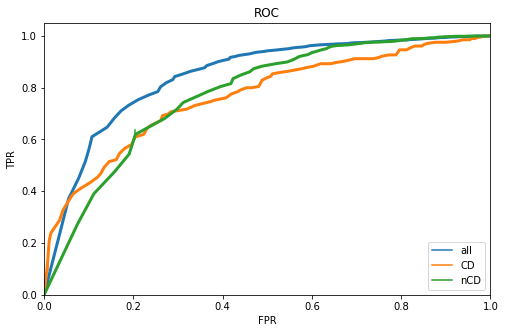

In [ ]:
summary_report(scores_baseline)
summary_plots(scores_baseline)

### Logreg
Попробуем добавить мета-модель (логрегрессию), которая объединит леса на основе структурных и филогенетических признаков и признак "CD".

In [ ]:
def run_meta(grid, df, n=10):
  """
  Run a meta-logregression model that combines structural and phylogenetic
  RFs' predictions with tuned coefficients (L2 regularisation).
  Args:
    grid: `max_features` values for tuning. 
    df: a dataframe with features and target variable.
    n: number of rounds (random train/test splitting). 
  Returns:
    scores: a dict with metrics for each round.
    conf_m: a confusion matrix for each round. 
    auc_dict: TPR, FPR and thresholds for each round.
  """
  mcc_scorer = make_scorer(matthews_corrcoef) # MCC function for later

  # dicts to return
  scores = {"Run_n": list(range(n)), "Best_param": [],
            "MCC": [], "F1": [], 
            "Precision": [], "Recall": [], 'Accuracy': [],
            'ROC-AUC': [], "PR-AUC": [], "Params": grid}
  conf_m = {"TN": [], "FP": [], "FN": [], "TP": [],
            "CD_TN": [], "CD_FP": [], "CD_FN": [], "CD_TP": [],
            "nCD_TN": [], "nCD_FP": [], "nCD_FN": [], "nCD_TP": []}
  auc_dict = {"Run": [], "TPR": [], "FPR": [], "THR": []}

  # split input dataframe into X, y and protein groups
  X, y, groups = df.drop(columns=["Acc",	'CV.SigShort'], axis=1), df['CV.SigShort'], df['Acc']

  stats = []
  for i in range(n):
    print()
    print("-------------------------------- ROUND ", i, "--------------------------------")

    # split into train and test (different proteins)
    train_inds, test_inds = next(GroupShuffleSplit(random_state=i).split(X, y, groups=groups))

    # save CD_statuses
    cds_test = X.iloc[test_inds]["CD"]
    cds_train = X.iloc[train_inds]["CD"]
    
    # make a sample for train and test
    X_train, X_test, y_train, y_test = X.iloc[train_inds], X.iloc[test_inds], y.iloc[train_inds], y.iloc[test_inds]

    # make separate dataframes for 2 RFs
    X_train_phyl, X_train_str = X_train[PHYL_FEAT], X_train[STRUCT_FEAT + ['SimpleClassRIN']]
    X_test_phyl, X_test_str = X_test[PHYL_FEAT], X_test[STRUCT_FEAT  + ['SimpleClassRIN']]
    
    # impute NaNs in both samples with feature medians
    si = SimpleImputer(strategy='median')
    X_train_phyl = si.fit_transform(X_train_phyl)
    X_test_phyl = si.transform(X_test_phyl)

    si = SimpleImputer(strategy='median')
    X_train_str = si.fit_transform(X_train_str)
    X_test_str = si.transform(X_test_str)
    
    # perform hyperparameter tuning for phylogenetic RF
    best_score = 0
    for k in [1, 2, 3]:
      rfc = RandomForestClassifier(random_state=42, oob_score=True, max_features=k)
      rfc.fit(X_train_phyl, y_train)
      curr_score = matthews_corrcoef(y_train, np.argmax(rfc.oob_decision_function_, axis=1))

      # update if better results
      if curr_score > best_score:
        best_score = curr_score
        best_model_phyl = rfc
    
    # perform hyperparameter tuning for structural RF
    best_score = 0
    for k in [1, 2, 3, 4, 5, 6, 7]:
      rfc = RandomForestClassifier(random_state=42, oob_score=True, max_features=k)
      rfc.fit(X_train_str, y_train)
      curr_score = matthews_corrcoef(y_train, np.argmax(rfc.oob_decision_function_, axis=1))

      # update if better results
      if curr_score > best_score:
        best_score = curr_score
        best_model_str = rfc

    # get predictions for the best RF models in this round
    pred_train_phyl = best_model_phyl.oob_decision_function_[:, 1]
    pred_test_phyl = best_model_phyl.predict_proba(X_test_phyl)[:, 1]
    pred_train_str = best_model_str.oob_decision_function_[:, 1]
    pred_test_str = best_model_str.predict_proba(X_test_str)[:, 1]

    # create dataframes with new features to use as an input to logreg:
    # α*(1-CD)*str + β*(1-CD)*phyl + γ*CD*str + δ*CD*phyl + ε*CD + b0 = y
    X_meta_train = pd.DataFrame(data={'CD': cds_train,
                                      '(1-CD)*str': (1-cds_train) * pred_train_str,
                                      '(1-CD)*phyl': (1-cds_train) * pred_train_phyl,
                                      'CD*str': cds_train * pred_train_str,
                                      'CD*phyl': cds_train * pred_train_phyl})
    X_meta_test = pd.DataFrame(data={'CD': cds_test,
                                     '(1-CD)*str': (1-cds_test) * pred_test_str,
                                     '(1-CD)*phyl': (1-cds_test) * pred_test_phyl,
                                     'CD*str': cds_test * pred_test_str,
                                     'CD*phyl': cds_test * pred_test_phyl})
    
    SCORING = {'Accuracy': "accuracy", "F1": 'f1', "Precision": "precision",
               "Recall": "recall", 'ROC-AUC': 'roc_auc', "PR-AUC": "average_precision",
               "MCC": mcc_scorer}
    
    # tune logreg model using CV with 10 folds and L2 regularisation
    CV_model = LogisticRegressionCV(Cs=grid,
                                    cv=10, 
                                    scoring=mcc_scorer,
                                    refit=True,
                                    n_jobs=-1, 
                                    verbose=5,
                                    random_state=i)
    
    # save best logreg model and append parameter list
    best_model = CV_model.fit(X_meta_train, y_train)
    best_parameter = best_model.C_
    stats.append([best_model.scores_, best_model.Cs_])

    # get predictions for the best model in this round
    pred_train = best_model.predict(X_meta_train)
    pred_test = best_model.predict(X_meta_test)
    proba_train = best_model.predict_proba(X_meta_train)[:, 1]
    proba_test = best_model.predict_proba(X_meta_test)[:, 1]

    # calculate metrics for the best model in this round
    metrics_train = calc_metrics(y_train, pred_train, proba_train)
    metrics_test = calc_metrics(y_test, pred_test, proba_test)
    scores["Best_param"].append(best_parameter)
    
    # report results for the round
    print()
    print("Best score for round {}: {:.2f}".format(i, best_score))
    print("Best parameter for round {}: {}".format(i, best_parameter))

    print()
    print("PREDICTIONS ON TRAIN:")
    print("-------------------------------")
    predict_cd(y_train, pred_train, proba_train, cds_train)
      
    print()
    print("PREDICTIONS ON TEST:")
    print("-------------------------------")
    res = predict_cd(y_test, pred_test, proba_test, cds_test)

    # save results for each round
    for s in metrics_train.keys(): scores[s].append([metrics_train[s], metrics_test[s], res[1][s][0], res[1][s][1]])
    for i in conf_m: conf_m[i].append(res[0][i]) 

    auc_dict = {"Run": [], "TPR": [], "FPR": [], "THR": [], "Type": []}
    for t in ["all", "CD", "nCD"]:
      for n in range(len(res[2][t])):
        auc_dict["Run"].extend(["i"] * len(res[2][t]["THR"]))
        auc_dict["Type"].extend([t] * len(res[2][t]["THR"]))
        auc_dict["TPR"].extend(res[2][t]["TPR"])
        auc_dict["FPR"].extend(res[2][t]["FPR"])
        auc_dict["THR"].extend(res[2][t]["THR"])

  return scores, conf_m, auc_dict

In [ ]:
C_grid = np.logspace(-4, 4, 20)
scores_meta = run_meta(C_grid, cv_df_all, n=10)

-------------------------------- ROUND  0 --------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.1s finished



Best score for round 0: 0.33
Best parameter for round 0: [11.28837892]

PREDICTIONS ON TRAIN:
-------------------------------
Confusion matrix for all:
TRUE\PRED	0		1
0		759(55.44%)	610(44.56%)
1		213(2.87%)	7208(97.13%)

Confusion matrix for CD:
TRUE\PRED	0		1
0		674(83.73%)	131(16.27%)
1		162(28.93%)	398(71.07%)

Confusion matrix for non-CD:
TRUE\PRED	0		1
0		85(15.07%)	479(84.93%)
1		51(0.74%)	6810(99.26%)

PREDICTIONS ON TEST:
-------------------------------
Confusion matrix for all:
TRUE\PRED	0		1
0		168(52.83%)	150(47.17%)
1		35(2.46%)	1388(97.54%)

Confusion matrix for CD:
TRUE\PRED	0		1
0		143(85.12%)	25(14.88%)
1		21(16.54%)	106(83.46%)

Confusion matrix for non-CD:
TRUE\PRED	0		1
0		25(16.67%)	125(83.33%)
1		14(1.08%)	1282(98.92%)
-------------------------------- ROUND  1 --------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.0s finished



Best score for round 1: 0.33
Best parameter for round 1: [4.2813324]

PREDICTIONS ON TRAIN:
-------------------------------
Confusion matrix for all:
TRUE\PRED	0		1
0		747(56.98%)	564(43.02%)
1		204(3.06%)	6470(96.94%)

Confusion matrix for CD:
TRUE\PRED	0		1
0		650(85.53%)	110(14.47%)
1		147(29.34%)	354(70.66%)

Confusion matrix for non-CD:
TRUE\PRED	0		1
0		97(17.60%)	454(82.40%)
1		57(0.92%)	6116(99.08%)

PREDICTIONS ON TEST:
-------------------------------
Confusion matrix for all:
TRUE\PRED	0		1
0		214(56.91%)	162(43.09%)
1		96(4.42%)	2074(95.58%)

Confusion matrix for CD:
TRUE\PRED	0		1
0		183(85.92%)	30(14.08%)
1		75(40.32%)	111(59.68%)

Confusion matrix for non-CD:
TRUE\PRED	0		1
0		31(19.02%)	132(80.98%)
1		21(1.06%)	1963(98.94%)
-------------------------------- ROUND  2 --------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.5s finished



Best score for round 2: 0.35
Best parameter for round 2: [4.2813324]

PREDICTIONS ON TRAIN:
-------------------------------
Confusion matrix for all:
TRUE\PRED	0		1
0		768(54.78%)	634(45.22%)
1		235(3.19%)	7125(96.81%)

Confusion matrix for CD:
TRUE\PRED	0		1
0		671(82.74%)	140(17.26%)
1		172(28.86%)	424(71.14%)

Confusion matrix for non-CD:
TRUE\PRED	0		1
0		97(16.41%)	494(83.59%)
1		63(0.93%)	6701(99.07%)

PREDICTIONS ON TEST:
-------------------------------
Confusion matrix for all:
TRUE\PRED	0		1
0		156(54.74%)	129(45.26%)
1		41(2.76%)	1443(97.24%)

Confusion matrix for CD:
TRUE\PRED	0		1
0		139(85.80%)	23(14.20%)
1		27(29.67%)	64(70.33%)

Confusion matrix for non-CD:
TRUE\PRED	0		1
0		17(13.82%)	106(86.18%)
1		14(1.01%)	1379(98.99%)
-------------------------------- ROUND  3 --------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.4s finished



Best score for round 3: 0.38
Best parameter for round 3: [29.76351442]

PREDICTIONS ON TRAIN:
-------------------------------
Confusion matrix for all:
TRUE\PRED	0		1
0		767(56.44%)	592(43.56%)
1		210(3.16%)	6446(96.84%)

Confusion matrix for CD:
TRUE\PRED	0		1
0		669(85.44%)	114(14.56%)
1		152(28.73%)	377(71.27%)

Confusion matrix for non-CD:
TRUE\PRED	0		1
0		98(17.01%)	478(82.99%)
1		58(0.95%)	6069(99.05%)

PREDICTIONS ON TEST:
-------------------------------
Confusion matrix for all:
TRUE\PRED	0		1
0		181(55.18%)	147(44.82%)
1		79(3.61%)	2109(96.39%)

Confusion matrix for CD:
TRUE\PRED	0		1
0		157(82.63%)	33(17.37%)
1		50(31.65%)	108(68.35%)

Confusion matrix for non-CD:
TRUE\PRED	0		1
0		24(17.39%)	114(82.61%)
1		29(1.43%)	2001(98.57%)
-------------------------------- ROUND  4 --------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.5s finished



Best score for round 4: 0.35
Best parameter for round 4: [11.28837892]

PREDICTIONS ON TRAIN:
-------------------------------
Confusion matrix for all:
TRUE\PRED	0		1
0		734(55.73%)	583(44.27%)
1		222(3.11%)	6909(96.89%)

Confusion matrix for CD:
TRUE\PRED	0		1
0		624(82.65%)	131(17.35%)
1		159(28.29%)	403(71.71%)

Confusion matrix for non-CD:
TRUE\PRED	0		1
0		110(19.57%)	452(80.43%)
1		63(0.96%)	6506(99.04%)

PREDICTIONS ON TEST:
-------------------------------
Confusion matrix for all:
TRUE\PRED	0		1
0		210(56.76%)	160(43.24%)
1		44(2.57%)	1669(97.43%)

Confusion matrix for CD:
TRUE\PRED	0		1
0		187(85.78%)	31(14.22%)
1		27(21.60%)	98(78.40%)

Confusion matrix for non-CD:
TRUE\PRED	0		1
0		23(15.13%)	129(84.87%)
1		17(1.07%)	1571(98.93%)
-------------------------------- ROUND  5 --------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.5s finished



Best score for round 5: 0.36
Best parameter for round 5: [0.61584821]

PREDICTIONS ON TRAIN:
-------------------------------
Confusion matrix for all:
TRUE\PRED	0		1
0		794(57.45%)	588(42.55%)
1		206(3.16%)	6313(96.84%)

Confusion matrix for CD:
TRUE\PRED	0		1
0		684(85.29%)	118(14.71%)
1		147(28.60%)	367(71.40%)

Confusion matrix for non-CD:
TRUE\PRED	0		1
0		110(18.97%)	470(81.03%)
1		59(0.98%)	5946(99.02%)

PREDICTIONS ON TEST:
-------------------------------
Confusion matrix for all:
TRUE\PRED	0		1
0		180(59.02%)	125(40.98%)
1		88(3.78%)	2237(96.22%)

Confusion matrix for CD:
TRUE\PRED	0		1
0		145(84.80%)	26(15.20%)
1		66(38.15%)	107(61.85%)

Confusion matrix for non-CD:
TRUE\PRED	0		1
0		35(26.12%)	99(73.88%)
1		22(1.02%)	2130(98.98%)
-------------------------------- ROUND  6 --------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.1s finished



Best score for round 6: 0.36
Best parameter for round 6: [0.61584821]

PREDICTIONS ON TRAIN:
-------------------------------
Confusion matrix for all:
TRUE\PRED	0		1
0		709(54.37%)	595(45.63%)
1		221(3.25%)	6575(96.75%)

Confusion matrix for CD:
TRUE\PRED	0		1
0		611(82.46%)	130(17.54%)
1		159(29.44%)	381(70.56%)

Confusion matrix for non-CD:
TRUE\PRED	0		1
0		98(17.41%)	465(82.59%)
1		62(0.99%)	6194(99.01%)

PREDICTIONS ON TEST:
-------------------------------
Confusion matrix for all:
TRUE\PRED	0		1
0		217(56.66%)	166(43.34%)
1		58(2.83%)	1990(97.17%)

Confusion matrix for CD:
TRUE\PRED	0		1
0		190(81.90%)	42(18.10%)
1		45(30.61%)	102(69.39%)

Confusion matrix for non-CD:
TRUE\PRED	0		1
0		27(17.88%)	124(82.12%)
1		13(0.68%)	1888(99.32%)
-------------------------------- ROUND  7 --------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.5s finished



Best score for round 7: 0.35
Best parameter for round 7: [1.62377674]

PREDICTIONS ON TRAIN:
-------------------------------
Confusion matrix for all:
TRUE\PRED	0		1
0		726(56.15%)	567(43.85%)
1		200(2.87%)	6759(97.13%)

Confusion matrix for CD:
TRUE\PRED	0		1
0		631(85.04%)	111(14.96%)
1		142(28.57%)	355(71.43%)

Confusion matrix for non-CD:
TRUE\PRED	0		1
0		95(17.24%)	456(82.76%)
1		58(0.90%)	6404(99.10%)

PREDICTIONS ON TEST:
-------------------------------
Confusion matrix for all:
TRUE\PRED	0		1
0		223(56.60%)	171(43.40%)
1		73(3.87%)	1812(96.13%)

Confusion matrix for CD:
TRUE\PRED	0		1
0		192(83.12%)	39(16.88%)
1		61(32.11%)	129(67.89%)

Confusion matrix for non-CD:
TRUE\PRED	0		1
0		31(19.02%)	132(80.98%)
1		12(0.71%)	1683(99.29%)
-------------------------------- ROUND  8 --------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.7s finished



Best score for round 8: 0.36
Best parameter for round 8: [4.2813324]

PREDICTIONS ON TRAIN:
-------------------------------
Confusion matrix for all:
TRUE\PRED	0		1
0		794(57.66%)	583(42.34%)
1		227(3.15%)	6980(96.85%)

Confusion matrix for CD:
TRUE\PRED	0		1
0		683(84.32%)	127(15.68%)
1		160(27.26%)	427(72.74%)

Confusion matrix for non-CD:
TRUE\PRED	0		1
0		111(19.58%)	456(80.42%)
1		67(1.01%)	6553(98.99%)

PREDICTIONS ON TEST:
-------------------------------
Confusion matrix for all:
TRUE\PRED	0		1
0		145(46.77%)	165(53.23%)
1		50(3.05%)	1587(96.95%)

Confusion matrix for CD:
TRUE\PRED	0		1
0		128(78.53%)	35(21.47%)
1		32(32.00%)	68(68.00%)

Confusion matrix for non-CD:
TRUE\PRED	0		1
0		17(11.56%)	130(88.44%)
1		18(1.17%)	1519(98.83%)
-------------------------------- ROUND  9 --------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.3s finished



Best score for round 9: 0.35
Best parameter for round 9: [4.2813324]

PREDICTIONS ON TRAIN:
-------------------------------
Confusion matrix for all:
TRUE\PRED	0		1
0		669(55.20%)	543(44.80%)
1		192(2.97%)	6263(97.03%)

Confusion matrix for CD:
TRUE\PRED	0		1
0		594(83.31%)	119(16.69%)
1		142(29.46%)	340(70.54%)

Confusion matrix for non-CD:
TRUE\PRED	0		1
0		75(15.03%)	424(84.97%)
1		50(0.84%)	5923(99.16%)

PREDICTIONS ON TEST:
-------------------------------
Confusion matrix for all:
TRUE\PRED	0		1
0		259(54.53%)	216(45.47%)
1		79(3.31%)	2310(96.69%)

Confusion matrix for CD:
TRUE\PRED	0		1
0		224(86.15%)	36(13.85%)
1		62(30.24%)	143(69.76%)

Confusion matrix for non-CD:
TRUE\PRED	0		1
0		35(16.28%)	180(83.72%)
1		17(0.78%)	2167(99.22%)


Confusion matrix for all:
TRUE\PRED	0		1
0		55.00 ± 3.18%	45.00 ± 3.18%
1		3.27 ± 0.61%	96.73 ± 0.61%

Confusion matrix for CD:
TRUE\PRED	0		1
0		83.97 ± 2.32%	16.03 ± 2.32%
1		30.29 ± 6.60%	69.71 ± 6.60%

Confusion matrix for non-CD:
TRUE\PRED	0		1
0		17.29 ± 3.68%	82.71 ± 3.68%
1		1.00 ± 0.22%	99.00 ± 0.22%

------------------------------------ SUMMARY ------------------------------------
MCC on train = 0.608 ± 0.020.
MCC on test = 0.591 ± 0.054.
MCC on CDs (test) = 0.543 ± 0.054.
MCC on non-CDs (test) = 0.292 ± 0.054.

F1 on train = 0.944 ± 0.004.
F1 on test = 0.943 ± 0.011.
F1 on CDs (test) = 0.725 ± 0.011.
F1 on non-CDs (test) = 0.960 ± 0.011.

Precision on train = 0.920 ± 0.006.
Precision on test = 0.920 ± 0.026.
Precision on CDs (test) = 0.760 ± 0.026.
Precision on non-CDs (test) = 0.931 ± 0.026.

Recall on train = 0.969 ± 0.003.
Recall on test = 0.967 ± 0.012.
Recall on CDs (test) = 0.697 ± 0.012.
Recall on non-CDs (test) = 0.990 ± 0.012.

Accuracy on train = 0.903 ± 0.006.
Acc

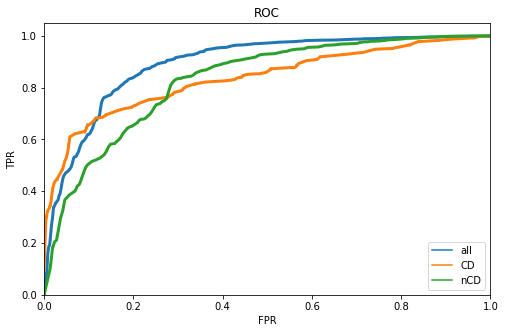

In [ ]:
summary_report(scores_meta)
summary_plots(scores_meta)

In [ ]:
with open('/content/drive/MyDrive/diploma/scores_meta.pickle', 'wb') as f: dump(scores_meta, f)

## Финальные модели

Видим, что леса не переобучаются и их результаты не зависят от разбиения выборки. Ещё раз обучим леса на одном разбиении, чтобы получить финальные предсказания, которые мы включим в исходный датафрейм.

### Обучение

In [ ]:
def final_model(grid, df):
  """
  Run a final RF model to get predictions.
  Args:
    grid: `max_features` values for tuning. 
    df: a dataframe with features and target variable.
  Returns:
    best_model: the best RF model.
  """
  mcc_scorer = make_scorer(matthews_corrcoef) # MCC function for later

  # split input dataframe into X, y and protein groups
  X, y, groups = df.drop(columns=["Acc",	'CV.SigShort'], axis=1), df['CV.SigShort'], df['Acc']

  # split into train and test (different proteins)
  train_inds, test_inds = next(GroupShuffleSplit(random_state=42).split(X, y, groups=groups))

  # save CD_statuses
  cds_test = X.iloc[test_inds]["CD"]
  cds_train = X.iloc[train_inds]["CD"]

  # make a sample for train and test
  X_train, X_test, y_train, y_test = X.iloc[train_inds], X.iloc[test_inds], y.iloc[train_inds], y.iloc[test_inds]
  X_train.drop(columns=["CD"], axis=1, inplace=True)
  X_test.drop(columns=["CD"], axis=1, inplace=True)

  # impute NaNs with feature medians
  si = SimpleImputer(strategy='median')
  X_train = si.fit_transform(X_train)
  X_test = si.transform(X_test)

  # perform hyperparameter tuning
  best_score = 0
  for k in grid:
    rfc = RandomForestClassifier(random_state=42, oob_score=True, max_features=k)
    rfc.fit(X_train, y_train)
    pred_train = np.argmax(rfc.oob_decision_function_, axis=1)
    curr_score = matthews_corrcoef(y_train, pred_train)

    # update if better results
    if curr_score > best_score:
      best_score = curr_score
      best_parameter = k
      best_model = rfc

  print("Best score: {:.2f}".format(best_score))
  print("Best parameter: {}".format(best_parameter))

  # get predictions for the best RF model
  pred_train = np.argmax(best_model.oob_decision_function_, axis=1)
  pred_test = best_model.predict(X_test)
  proba_train = best_model.oob_decision_function_[:, 1]
  proba_test = best_model.predict_proba(X_test)[:, 1]

  # calculate metrics for the best model 
  metrics_train = calc_metrics(y_train, pred_train, proba_train)
  metrics_test = calc_metrics(y_test, pred_test, proba_test)

  # report results
  print()
  print("PREDICTIONS ON TRAIN:")
  print("-------------------------------")
  predict_cd(y_train, pred_train, proba_train, cds_train)
  print(metrics_train)

  print()
  print("PREDICTIONS ON TEST:")
  print("-------------------------------")
  predict_cd(y_test, pred_test, proba_test, cds_test)
  print(metrics_test)

  return best_model


In [ ]:
final_model_all = final_model([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], cv_df_all)

Best score: 0.60
Best parameter: 2

PREDICTIONS ON TRAIN:
-------------------------------
Confusion matrix for all:
TRUE\PRED	0		1
0		759(55.69%)	604(44.31%)
1		226(3.14%)	6968(96.86%)

Confusion matrix for CD:
TRUE\PRED	0		1
0		618(78.63%)	168(21.37%)
1		119(22.62%)	407(77.38%)

Confusion matrix for non-CD:
TRUE\PRED	0		1
0		141(24.44%)	436(75.56%)
1		107(1.60%)	6561(98.40%)
{'Accuracy': 0.9030033890382143, 'MCC': 0.6024719407298648, 'F1': 0.9437897873493161, 'Precision': 0.9202324352879028, 'Recall': 0.9685849318876841, 'ROC-AUC': 0.8876581242500323, 'PR-AUC': 0.9681171012735557}

PREDICTIONS ON TEST:
-------------------------------
Confusion matrix for all:
TRUE\PRED	0		1
0		176(54.32%)	148(45.68%)
1		36(2.18%)	1614(97.82%)

Confusion matrix for CD:
TRUE\PRED	0		1
0		143(76.47%)	44(23.53%)
1		19(11.80%)	142(88.20%)

Confusion matrix for non-CD:
TRUE\PRED	0		1
0		33(24.09%)	104(75.91%)
1		17(1.14%)	1472(98.86%)
{'Accuracy': 0.9067882472137792, 'MCC': 0.6237458996486431, 'F1': 0.94607

In [ ]:
final_model_phyl = final_model([1, 2, 3], cv_df_phyl)

Best score: 0.55
Best parameter: 2

PREDICTIONS ON TRAIN:
-------------------------------
Confusion matrix for all:
TRUE\PRED	0		1
0		715(52.46%)	648(47.54%)
1		297(4.13%)	6897(95.87%)

Confusion matrix for CD:
TRUE\PRED	0		1
0		585(74.43%)	201(25.57%)
1		132(25.10%)	394(74.90%)

Confusion matrix for non-CD:
TRUE\PRED	0		1
0		130(22.53%)	447(77.47%)
1		165(2.47%)	6503(97.53%)
{'Accuracy': 0.8895640995676055, 'MCC': 0.5476769077575849, 'F1': 0.9358843883574192, 'Precision': 0.9141153081510934, 'Recall': 0.9587155963302753, 'ROC-AUC': 0.8527422889091363, 'PR-AUC': 0.9560389777308292}

PREDICTIONS ON TEST:
-------------------------------
Confusion matrix for all:
TRUE\PRED	0		1
0		171(52.78%)	153(47.22%)
1		51(3.09%)	1599(96.91%)

Confusion matrix for CD:
TRUE\PRED	0		1
0		137(73.26%)	50(26.74%)
1		21(13.04%)	140(86.96%)

Confusion matrix for non-CD:
TRUE\PRED	0		1
0		34(24.82%)	103(75.18%)
1		30(2.01%)	1459(97.99%)
{'Accuracy': 0.8966565349544073, 'MCC': 0.582522315346604, 'F1': 0.940035

In [ ]:
final_model_str = final_model([1, 2, 3, 4, 5, 6, 7], cv_df_str)

Best score: 0.37
Best parameter: 7

PREDICTIONS ON TRAIN:
-------------------------------
Confusion matrix for all:
TRUE\PRED	0		1
0		478(35.07%)	885(64.93%)
1		367(5.10%)	6827(94.90%)

Confusion matrix for CD:
TRUE\PRED	0		1
0		333(42.37%)	453(57.63%)
1		64(12.17%)	462(87.83%)

Confusion matrix for non-CD:
TRUE\PRED	0		1
0		145(25.13%)	432(74.87%)
1		303(4.54%)	6365(95.46%)
{'Accuracy': 0.8536870398504148, 'MCC': 0.3676057629600404, 'F1': 0.9160069770562189, 'Precision': 0.8852437759336099, 'Recall': 0.948985265499027, 'ROC-AUC': 0.8056527296836384, 'PR-AUC': 0.946139474687067}

PREDICTIONS ON TEST:
-------------------------------
Confusion matrix for all:
TRUE\PRED	0		1
0		103(31.79%)	221(68.21%)
1		100(6.06%)	1550(93.94%)

Confusion matrix for CD:
TRUE\PRED	0		1
0		71(37.97%)	116(62.03%)
1		18(11.18%)	143(88.82%)

Confusion matrix for non-CD:
TRUE\PRED	0		1
0		32(23.36%)	105(76.64%)
1		82(5.51%)	1407(94.49%)
{'Accuracy': 0.837386018237082, 'MCC': 0.31375367250699604, 'F1': 0.9061677

In [ ]:
from joblib import dump, load
dump(final_model_all, '/content/drive/MyDrive/diploma/rfc_all_hard.joblib') 
dump(final_model_str, '/content/drive/MyDrive/diploma/rfc_str_hard.joblib') 
dump(final_model_phyl, '/content/drive/MyDrive/diploma/rfc_phyl_hard.joblib') 

# rbc_loaded = load('/content/drive/MyDrive/diploma/rfc_struct.joblib')

['/content/drive/MyDrive/diploma/rfc_phyl_hard.joblib']

In [ ]:
def preprocess(df):
  """
  Preprocess dataframe so it can be used as an input to a model.
  Args:
    df: a dataframe to preprocess.
  Returns:
    X: a preprocessed dataframe.
  """
  X = df.drop(columns=["Acc",	'CV.SigShort', 'CPD', 'CV.SigShort'], axis=1) 
    
  si = SimpleImputer(strategy='median')
  X = si.fit_transform(X)

  return(X)

Сделаем предсказания финальными моделями, добавим в датафрейм, сохраним:

In [ ]:
cv_df["Forest_10_hard_pred"] = final_model_all.predict(preprocess(cv_df_all))
cv_df["Forest_phyl_hard_pred"] = final_model_phyl.predict(preprocess(cv_df_phyl))
cv_df["Forest_str_hard_pred"] = final_model_str.predict(preprocess(cv_df_str))
cv_df.to_csv('/content/drive/MyDrive/diploma/table_w_pred.csv')

### Feature importance

In [ ]:
def feature_importance(model, df):
  """
  Calculate feature importance for the RF model (MDA and MDI).
  Args:
    model: an RF model to use for calculations.
    df: a dataframe with variants.
  """
  # calculate MDI feature importancce
  mdi = model.feature_importances_
  sorted_idx = mdi.argsort()
  feature_names = df.drop(columns=["Acc", "CPD", "CV.SigShort"]).columns

  # plot 
  y_ticks = np.arange(0, model.n_features_)
  fig, ax = plt.subplots(figsize=(10,5))
  ax.barh(y_ticks, mdi[sorted_idx])
  ax.set_yticklabels(feature_names[sorted_idx])
  ax.set_yticks(y_ticks)
  ax.set_title("Random Forest Feature Importances (MDI)")
  fig.tight_layout()
  plt.show();


  ct = ColumnTransformer([('num', SimpleImputer(strategy='median'),
                           feature_names)], remainder = "passthrough")
  X = ct.fit_transform(df.drop(columns=["Acc", "CD", "CV.SigShort"], axis=1))

  # calculate MDA feature importance
  pi = permutation_importance(model, X, df["CV.SigShort"], n_repeats=20, random_state=42)
  sorted_idx = pi.importances_mean.argsort()

  # plot
  fig, ax = plt.subplots(figsize=(10,5))
  ax.boxplot(pi.importances[sorted_idx].T,
            vert=False, labels=feature_names[sorted_idx])
  ax.set_title("Permutation Importances (train set)")
  fig.tight_layout()
  plt.show();

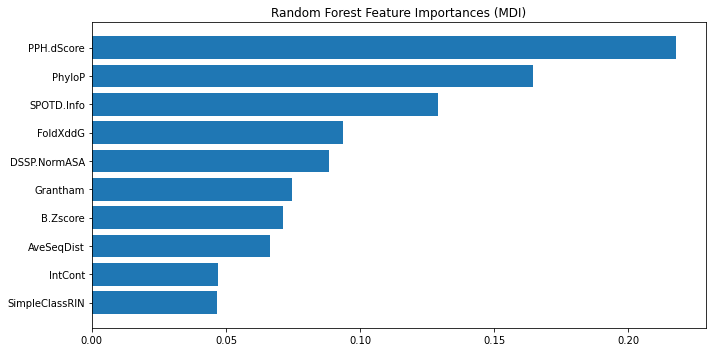

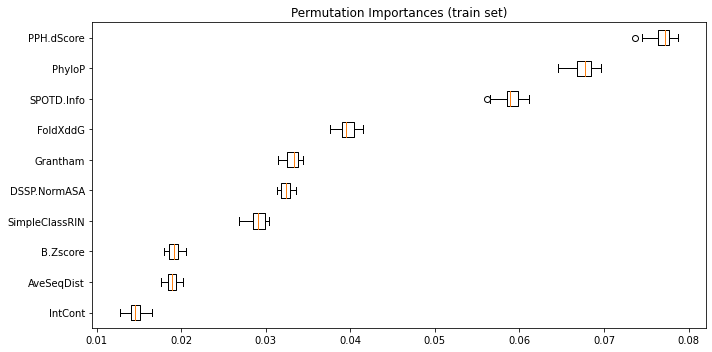

In [ ]:
feature_importance(final_model_all, cv_df_all)

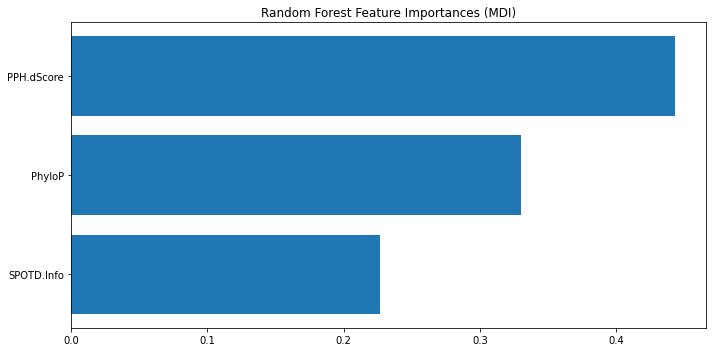

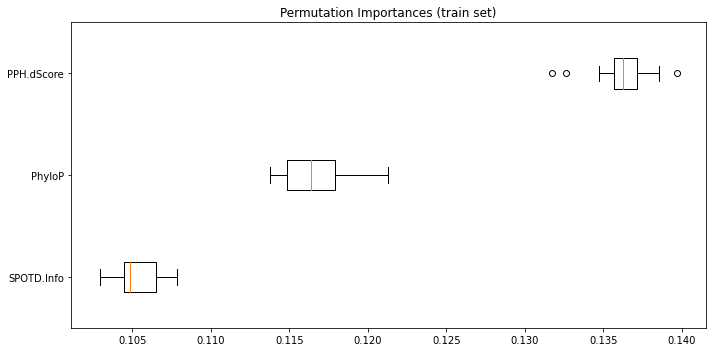

In [ ]:
feature_importance(final_model_phyl, cv_df_phyl)

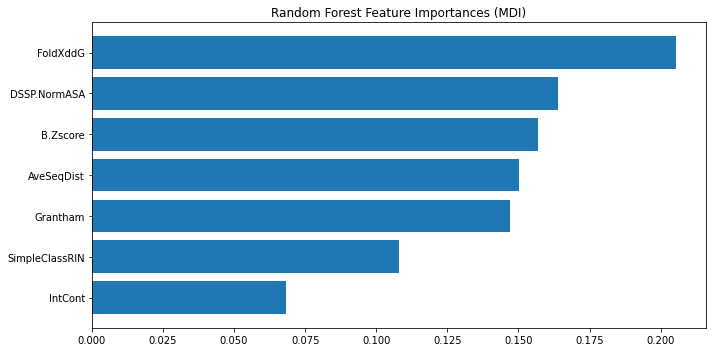

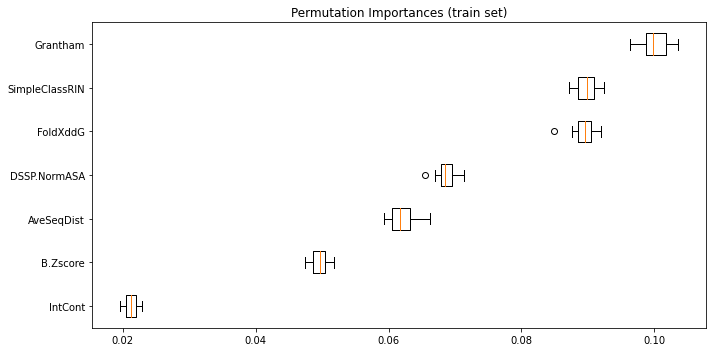

In [ ]:
feature_importance(final_model_str, cv_df_str)